# PDEBench Data Visualization

This notebook visualizes generated PDE simulation data:
- **1D Burgers Equation** (`.npz` files)
- **2D Navier-Stokes Incompressible** (`.h5` files)

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import Normalize
from IPython.display import HTML, display
import os
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for animations
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['animation.embed_limit'] = 100  # MB limit for embedded animations

---
# Part 1: 1D Burgers Equation

The Burgers equation is a fundamental PDE combining nonlinear wave propagation with diffusion:
$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

In [2]:
# List available Burgers data files
burgers_files = sorted([f for f in os.listdir('.') if f.startswith('burgers') and f.endswith('.npz')])
print("Available Burgers datasets:")
for f in burgers_files:
    print(f"  - {f}")

Available Burgers datasets:
  - burgers1D_training_data_Nu0.001.npz
  - burgers1D_training_data_Nu0.01.npz
  - burgers1D_training_data_Nu0.1.npz
  - burgers1D_training_data_Nu0.5.npz


In [3]:
def load_burgers(filename):
    """Load Burgers equation data from npz file."""
    data = np.load(filename)
    return {
        'u': data['u'],      # Solution: (n_time, n_space)
        'x': data['x'],      # Spatial coordinates
        't': data['t'],      # Time values
    }

# Load one dataset
if burgers_files:
    burgers_data = load_burgers(burgers_files[0])
    print(f"Loaded: {burgers_files[0]}")
    print(f"  u shape: {burgers_data['u'].shape} (time, space)")
    print(f"  x range: [{burgers_data['x'].min():.4f}, {burgers_data['x'].max():.4f}]")
    print(f"  t range: [{burgers_data['t'].min():.4f}, {burgers_data['t'].max():.4f}]")
    print(f"  u range: [{burgers_data['u'].min():.4f}, {burgers_data['u'].max():.4f}]")

Loaded: burgers1D_training_data_Nu0.001.npz
  u shape: (201, 1024) (time, space)
  x range: [-0.9990, 0.9990]
  t range: [0.0000, 2.0100]
  u range: [-1.0000, 1.0000]


## 1.1 Burgers: Snapshots at Different Times

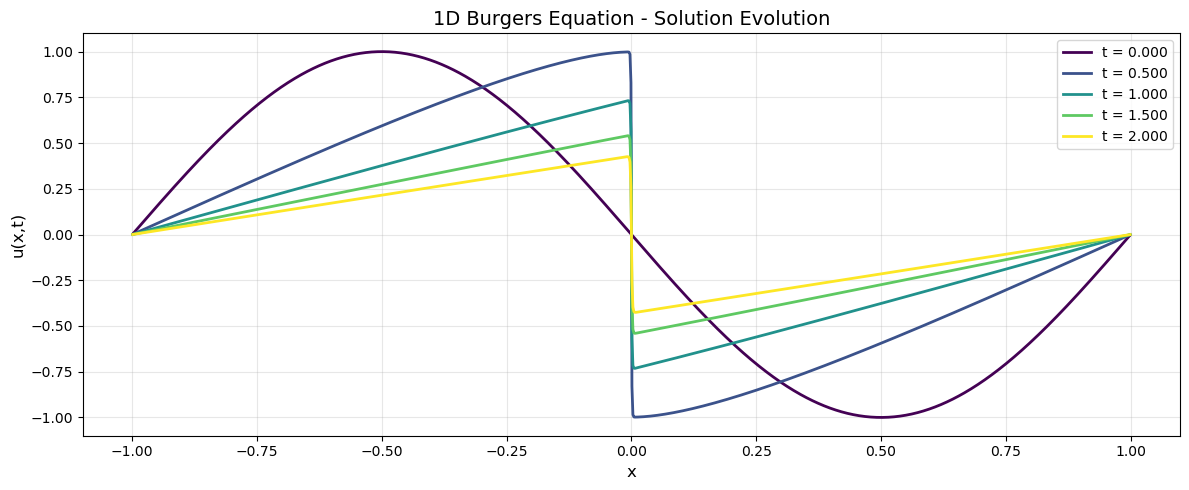

In [4]:
def plot_burgers_snapshots(data, n_snapshots=5):
    """Plot solution snapshots at different times."""
    u, x, t = data['u'], data['x'], data['t']
    n_time = u.shape[0]
    time_indices = np.linspace(0, n_time-1, n_snapshots, dtype=int)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    colors = plt.cm.viridis(np.linspace(0, 1, n_snapshots))
    
    for i, idx in enumerate(time_indices):
        ax.plot(x, u[idx], color=colors[i], label=f't = {t[idx]:.3f}', linewidth=2)
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('u(x,t)', fontsize=12)
    ax.set_title('1D Burgers Equation - Solution Evolution', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

if burgers_files:
    plot_burgers_snapshots(burgers_data)
    plt.show()

## 1.2 Burgers: Space-Time Heatmap

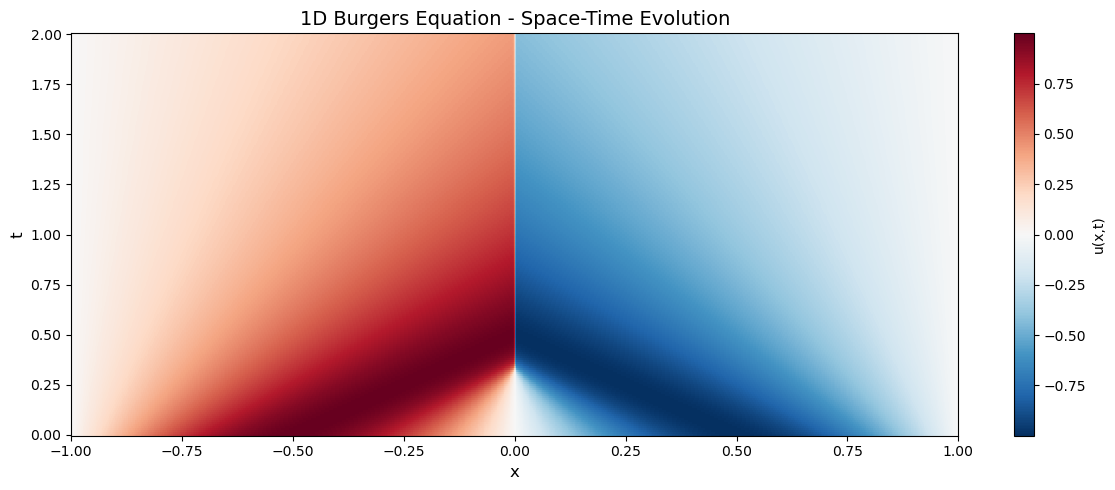

In [5]:
def plot_burgers_heatmap(data):
    """Plot space-time heatmap of the solution."""
    u, x, t = data['u'], data['x'], data['t']
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Create meshgrid for pcolormesh
    T, X = np.meshgrid(t[:u.shape[0]], x, indexing='ij')
    
    im = ax.pcolormesh(X, T, u, cmap='RdBu_r', shading='auto')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('t', fontsize=12)
    ax.set_title('1D Burgers Equation - Space-Time Evolution', fontsize=14)
    plt.colorbar(im, ax=ax, label='u(x,t)')
    plt.tight_layout()
    return fig

if burgers_files:
    plot_burgers_heatmap(burgers_data)
    plt.show()

## 1.3 Burgers: Animation

In [6]:
from IPython.display import display

def animate_burgers(data, skip=2, interval=50):
    """Create animation of Burgers equation evolution."""
    u, x, t = data['u'], data['x'], data['t']
    n_frames = u.shape[0] // skip
    
    fig, ax = plt.subplots(figsize=(10, 5))
    line, = ax.plot(x, u[0], 'b-', linewidth=2)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(u.min() - 0.1, u.max() + 0.1)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('u(x,t)', fontsize=12)
    ax.grid(True, alpha=0.3)
    title = ax.set_title(f'1D Burgers Equation  |  t = {t[0]:.4f}', fontsize=14)
    plt.tight_layout()
    
    def animate(frame):
        idx = frame * skip
        line.set_ydata(u[idx])
        title.set_text(f'1D Burgers Equation  |  t = {t[idx]:.4f}')
        return [line, title]
    
    anim = animation.FuncAnimation(fig, animate, frames=n_frames, interval=interval, blit=True)
    plt.close(fig)
    return anim

if burgers_files:
    burgers_anim = animate_burgers(burgers_data, skip=2, interval=30)
    display(HTML(burgers_anim.to_jshtml()))

## 1.4 Compare Different Viscosities

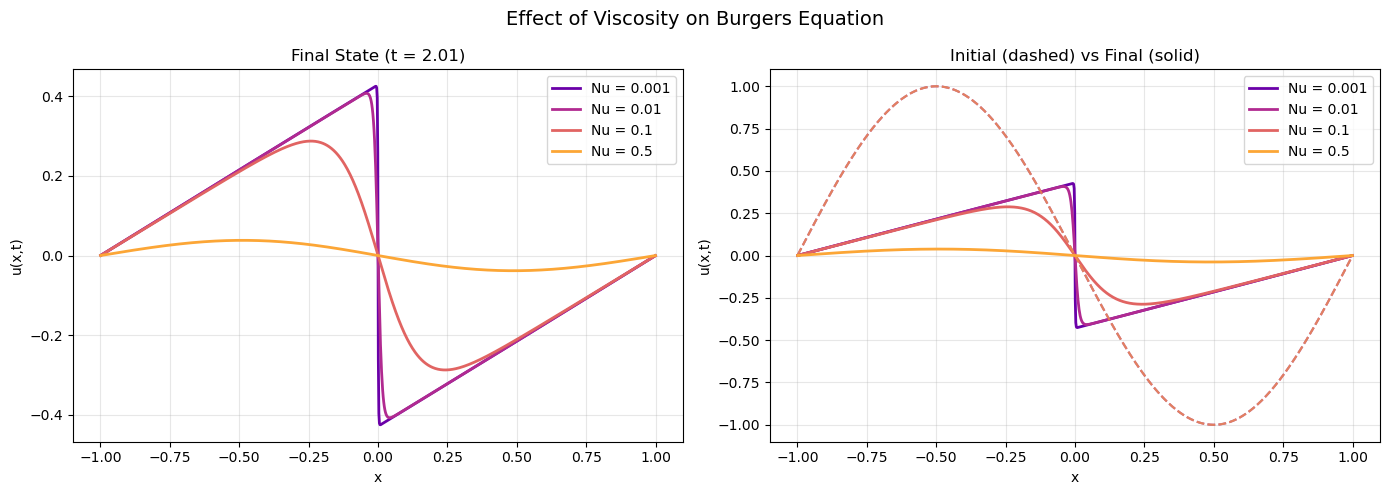

In [7]:
def compare_burgers_viscosities(files, time_idx=-1):
    """Compare solutions with different viscosities at a given time."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(files)))
    
    for i, f in enumerate(files):
        data = load_burgers(f)
        # Extract Nu from filename
        nu = f.split('Nu')[1].replace('.npz', '')
        
        # Final time snapshot
        axes[0].plot(data['x'], data['u'][time_idx], color=colors[i], 
                     label=f'Nu = {nu}', linewidth=2)
        
        # Heatmap (small version)
        axes[1].plot(data['x'], data['u'][0], '--', color=colors[i], alpha=0.5)
        axes[1].plot(data['x'], data['u'][time_idx], '-', color=colors[i], 
                     label=f'Nu = {nu}', linewidth=2)
    
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('u(x,t)')
    axes[0].set_title(f'Final State (t = {data["t"][time_idx]:.2f})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('u(x,t)')
    axes[1].set_title('Initial (dashed) vs Final (solid)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Effect of Viscosity on Burgers Equation', fontsize=14)
    plt.tight_layout()
    return fig

if len(burgers_files) > 1:
    compare_burgers_viscosities(burgers_files)
    plt.show()

---
# Part 2: 2D Navier-Stokes Incompressible

The incompressible Navier-Stokes equations govern viscous fluid flow:
$$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{f}$$
$$\nabla \cdot \mathbf{u} = 0$$

In [8]:
# List available NS data files
ns_files = sorted([f for f in os.listdir('.') if f.endswith('.h5')])
print("Available Navier-Stokes datasets:")
for f in ns_files:
    size = os.path.getsize(f) / 1024
    print(f"  - {f} ({size:.1f} KB)")

Available Navier-Stokes datasets:
  - ns_sim_2d-1.h5 (6.5 KB)
  - ns_sim_2d_test-1.h5 (61.3 KB)
  - ns_sim_2d_test-42.h5 (56.9 KB)
  - ns_sim_final-42.h5 (502.7 KB)
  - ns_sim_stable-123.h5 (57.2 KB)
  - ns_sim_v3-42.h5 (157.5 KB)


In [9]:
def load_ns(filename):
    """Load Navier-Stokes data from HDF5 file."""
    with h5py.File(filename, 'r') as f:
        data = {
            'velocity': f['velocity'][:],
            'particles': f['particles'][:],
            'force': f['force'][:],
            't': f['t'][:],
        }
    return data

# Load the valid simulation file
ns_filename = 'ns_sim_final-42.h5'
if ns_filename in ns_files:
    ns_data = load_ns(ns_filename)
    print(f"Loaded: {ns_filename}")
    print(f"  velocity shape: {ns_data['velocity'].shape}")
    print(f"  particles shape: {ns_data['particles'].shape}")
    print(f"  velocity range: [{ns_data['velocity'].min():.4f}, {ns_data['velocity'].max():.4f}]")
    print(f"  particles range: [{ns_data['particles'].min():.4f}, {ns_data['particles'].max():.4f}]")
else:
    print(f"File {ns_filename} not found. Available files: {ns_files}")

Loaded: ns_sim_final-42.h5
  velocity shape: (1, 10, 64, 64, 2)
  particles shape: (1, 10, 64, 64, 1)
  velocity range: [-2.6082, 2.3845]
  particles range: [-3.6801, 3.6373]


## 2.1 NS: Velocity Field Visualization

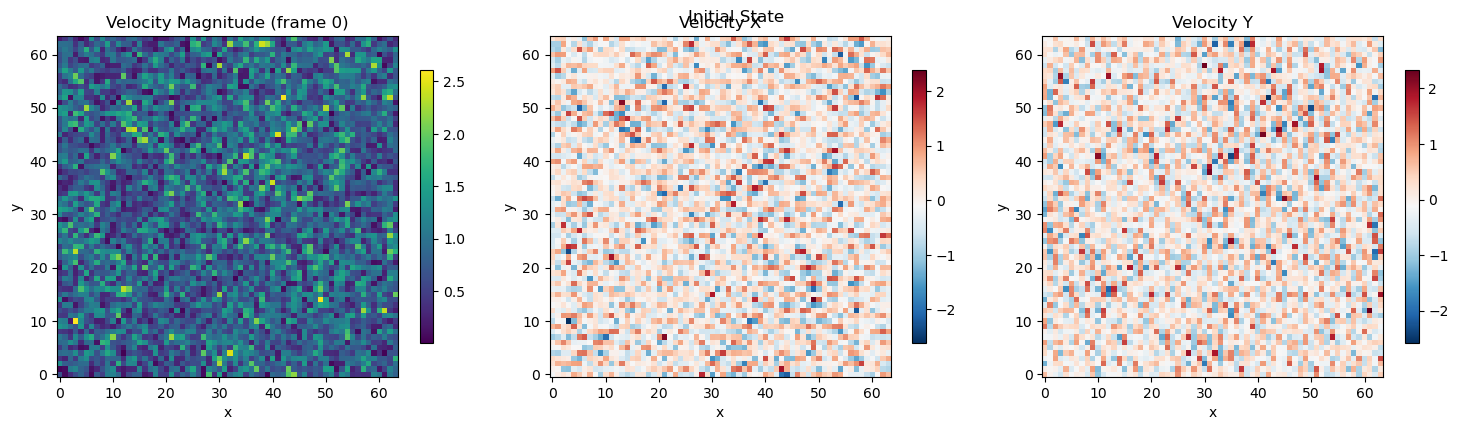

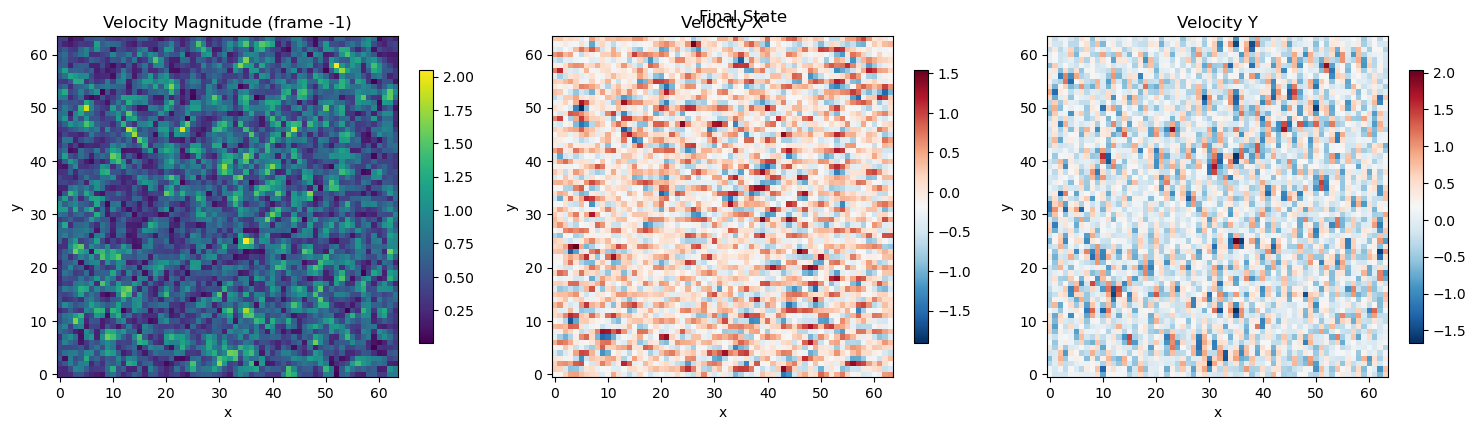

In [10]:
def plot_ns_velocity(data, frame_idx=0, batch_idx=0):
    """Plot velocity field components and magnitude."""
    vel = data['velocity'][batch_idx, frame_idx]
    vx, vy = vel[:, :, 0], vel[:, :, 1]
    vmag = np.sqrt(vx**2 + vy**2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    im0 = axes[0].imshow(vmag.T, origin='lower', cmap='viridis')
    axes[0].set_title(f'Velocity Magnitude (frame {frame_idx})')
    plt.colorbar(im0, ax=axes[0], shrink=0.8)
    
    im1 = axes[1].imshow(vx.T, origin='lower', cmap='RdBu_r')
    axes[1].set_title('Velocity X')
    plt.colorbar(im1, ax=axes[1], shrink=0.8)
    
    im2 = axes[2].imshow(vy.T, origin='lower', cmap='RdBu_r')
    axes[2].set_title('Velocity Y')
    plt.colorbar(im2, ax=axes[2], shrink=0.8)
    
    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    
    plt.tight_layout()
    return fig

if 'ns_data' in dir():
    plot_ns_velocity(ns_data, frame_idx=0)
    plt.suptitle('Initial State', y=1.02)
    plt.show()
    
    plot_ns_velocity(ns_data, frame_idx=-1)
    plt.suptitle('Final State', y=1.02)
    plt.show()

## 2.2 NS: Particle Density Evolution

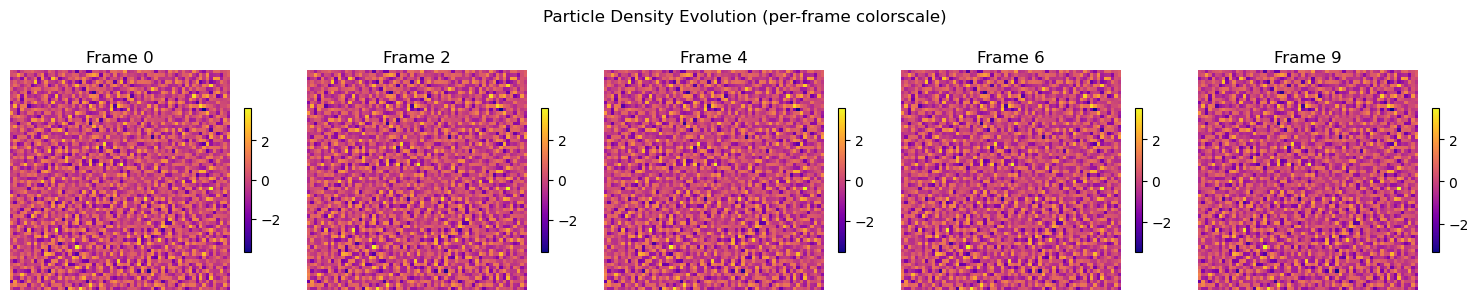

Note: Particle density range is very small: [-3.6801, 3.6373]
The simulation may need more time steps to show significant evolution.


In [11]:
def plot_ns_particles(data, batch_idx=0):
    """Plot particle density at multiple time steps."""
    particles = data['particles'][batch_idx]
    n_frames = particles.shape[0]
    n_show = min(5, n_frames)
    frame_indices = np.linspace(0, n_frames-1, n_show, dtype=int)
    
    fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
    if n_show == 1:
        axes = [axes]
    
    # Use per-frame normalization to show structure better
    for i, idx in enumerate(frame_indices):
        p = particles[idx, :, :, 0]
        im = axes[i].imshow(p.T, origin='lower', cmap='plasma')
        axes[i].set_title(f'Frame {idx}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], shrink=0.6)
    
    plt.suptitle('Particle Density Evolution (per-frame colorscale)', y=1.02)
    plt.tight_layout()
    return fig

if 'ns_data' in dir():
    plot_ns_particles(ns_data)
    plt.show()
    
    # Also show the actual range
    p = ns_data['particles']
    print(f"Note: Particle density range is very small: [{p.min():.4f}, {p.max():.4f}]")
    print(f"The simulation may need more time steps to show significant evolution.")

## 2.3 NS: Vector Field with Quiver Plot

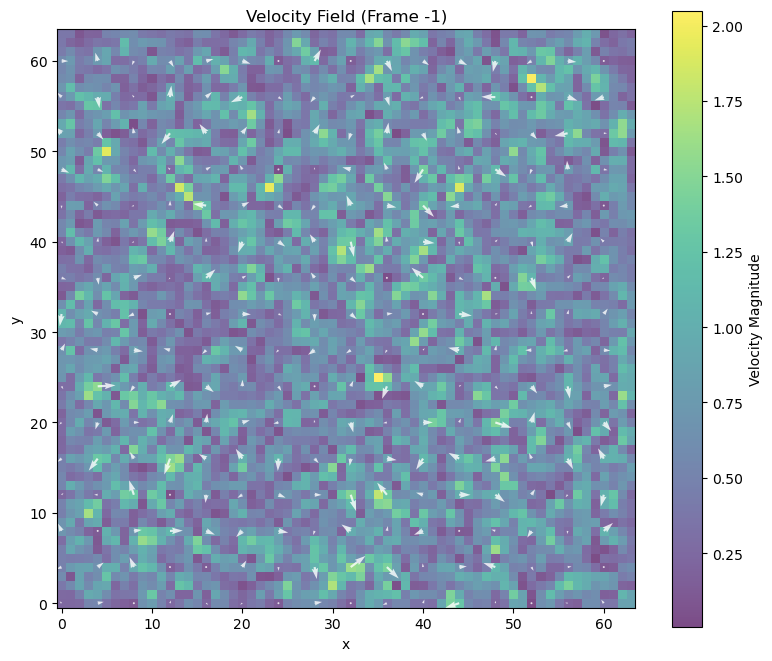

In [12]:
def plot_ns_quiver(data, frame_idx=0, batch_idx=0, skip=4):
    """Plot velocity field as quiver plot overlaid on magnitude."""
    vel = data['velocity'][batch_idx, frame_idx]
    vx, vy = vel[:, :, 0], vel[:, :, 1]
    vmag = np.sqrt(vx**2 + vy**2)
    
    ny, nx = vx.shape
    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Background: velocity magnitude
    im = ax.imshow(vmag.T, origin='lower', cmap='viridis', alpha=0.7)
    
    # Quiver: velocity vectors (subsampled)
    ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
              vx.T[::skip, ::skip], vy.T[::skip, ::skip],
              color='white', alpha=0.8, scale=50)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Velocity Field (Frame {frame_idx})')
    plt.colorbar(im, ax=ax, label='Velocity Magnitude', shrink=0.8)
    plt.tight_layout()
    return fig

if 'ns_data' in dir():
    plot_ns_quiver(ns_data, frame_idx=-1, skip=4)
    plt.show()

## 2.4 NS: Animation

In [13]:
def animate_ns(data, batch_idx=0, interval=500):
    """Create animation of NS flow evolution."""
    vel = data['velocity'][batch_idx]
    particles = data['particles'][batch_idx]
    n_frames = vel.shape[0]
    
    # Compute velocity magnitude for all frames
    vx = vel[:, :, :, 0]
    vy = vel[:, :, :, 1]
    vmag = np.sqrt(vx**2 + vy**2)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Use dynamic normalization to show changes better
    # Initialize plots with first frame
    im0 = axes[0].imshow(vmag[0].T, origin='lower', cmap='viridis')
    axes[0].set_title('Velocity Magnitude')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    cbar0 = plt.colorbar(im0, ax=axes[0], shrink=0.8)
    
    im1 = axes[1].imshow(particles[0, :, :, 0].T, origin='lower', cmap='RdBu_r')
    axes[1].set_title('Particle Density')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    cbar1 = plt.colorbar(im1, ax=axes[1], shrink=0.8)
    
    title = fig.suptitle(f'Frame 0 / {n_frames-1}', fontsize=14)
    plt.tight_layout()
    
    def animate(frame):
        # Update velocity plot with per-frame normalization
        v = vmag[frame].T
        im0.set_array(v)
        im0.set_clim(v.min(), v.max())
        
        # Update particles plot
        p = particles[frame, :, :, 0].T
        im1.set_array(p)
        im1.set_clim(p.min(), p.max())
        
        title.set_text(f'Frame {frame} / {n_frames-1}')
        return [im0, im1, title]
    
    anim = animation.FuncAnimation(fig, animate, frames=n_frames, 
                                   interval=interval, blit=False)  # blit=False for clim updates
    plt.close(fig)
    return anim

if 'ns_data' in dir():
    print(f"Creating animation with {ns_data['velocity'].shape[1]} frames...")
    print(f"Velocity magnitude decreases from ~0.85 to ~0.64 over time (diffusion)")
    ns_anim = animate_ns(ns_data, interval=600)
    display(HTML(ns_anim.to_jshtml()))

Creating animation with 10 frames...
Velocity magnitude decreases from ~0.85 to ~0.64 over time (diffusion)


## 2.5 NS: External Force Field

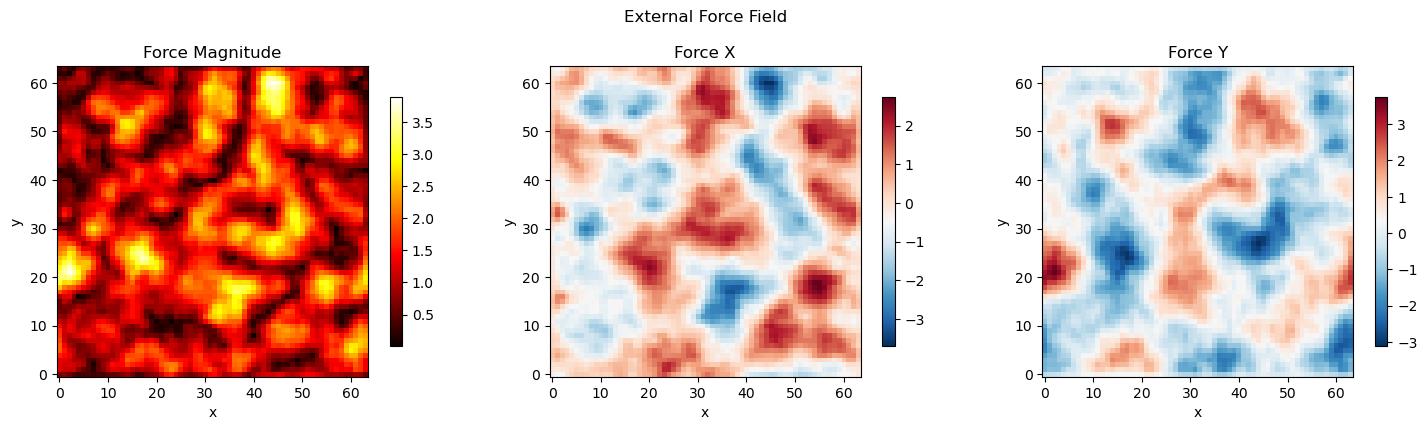

In [14]:
def plot_ns_force(data, batch_idx=0):
    """Plot the external force field."""
    force = data['force'][batch_idx]
    fx, fy = force[:, :, 0], force[:, :, 1]
    fmag = np.sqrt(fx**2 + fy**2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    im0 = axes[0].imshow(fmag.T, origin='lower', cmap='hot')
    axes[0].set_title('Force Magnitude')
    plt.colorbar(im0, ax=axes[0], shrink=0.8)
    
    im1 = axes[1].imshow(fx.T, origin='lower', cmap='RdBu_r')
    axes[1].set_title('Force X')
    plt.colorbar(im1, ax=axes[1], shrink=0.8)
    
    im2 = axes[2].imshow(fy.T, origin='lower', cmap='RdBu_r')
    axes[2].set_title('Force Y')
    plt.colorbar(im2, ax=axes[2], shrink=0.8)
    
    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    
    plt.suptitle('External Force Field', y=1.02)
    plt.tight_layout()
    return fig

if 'ns_data' in dir():
    plot_ns_force(ns_data)
    plt.show()

---
# Part 3: Summary Statistics

In [15]:
print("=" * 60)
print("DATA SUMMARY")
print("=" * 60)

print("\n--- Burgers Equation Datasets ---")
for f in burgers_files:
    data = load_burgers(f)
    nu = f.split('Nu')[1].replace('.npz', '')
    print(f"  {f}")
    print(f"    Nu = {nu}, grid = {data['u'].shape[1]}, time steps = {data['u'].shape[0]}")

print("\n--- Navier-Stokes Datasets ---")
for f in ns_files:
    try:
        data = load_ns(f)
        has_nan = np.isnan(data['velocity']).any()
        status = "VALID" if not has_nan else "HAS NaN"
        print(f"  {f} [{status}]")
        print(f"    velocity: {data['velocity'].shape}, particles: {data['particles'].shape}")
    except Exception as e:
        print(f"  {f} [ERROR: {e}]")

DATA SUMMARY

--- Burgers Equation Datasets ---
  burgers1D_training_data_Nu0.001.npz
    Nu = 0.001, grid = 1024, time steps = 201
  burgers1D_training_data_Nu0.01.npz
    Nu = 0.01, grid = 1024, time steps = 201
  burgers1D_training_data_Nu0.1.npz
    Nu = 0.1, grid = 1024, time steps = 201
  burgers1D_training_data_Nu0.5.npz
    Nu = 0.5, grid = 1024, time steps = 201

--- Navier-Stokes Datasets ---
  ns_sim_2d-1.h5 [VALID]
    velocity: (1, 10, 64, 64, 2), particles: (1, 10, 64, 64, 1)
  ns_sim_2d_test-1.h5 [HAS NaN]
    velocity: (1, 10, 64, 64, 2), particles: (1, 10, 64, 64, 1)
  ns_sim_2d_test-42.h5 [HAS NaN]
    velocity: (1, 10, 64, 64, 2), particles: (1, 10, 64, 64, 1)
  ns_sim_final-42.h5 [VALID]
    velocity: (1, 10, 64, 64, 2), particles: (1, 10, 64, 64, 1)
  ns_sim_stable-123.h5 [HAS NaN]
    velocity: (1, 10, 64, 64, 2), particles: (1, 10, 64, 64, 1)
  ns_sim_v3-42.h5 [VALID]
    velocity: (1, 10, 64, 64, 2), particles: (1, 10, 64, 64, 1)
